In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time

import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, SMOTENC

import sklearn
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, auc, \
    classification_report, multilabel_confusion_matrix, precision_recall_curve, roc_curve, average_precision_score, \
    make_scorer
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV
from hyperopt import hp,fmin, tpe, Trials
from hyperopt.pyll.base import scope
from functools import partial
from skopt import space
from skopt import gp_minimize

from src.config import Config
from src.analysis import Analysis
from src.train import Train

analysis = Analysis()
train = Train()

pd.set_option('display.max_rows', 500)

In [16]:
combined_df1 = analysis.read_file("./data/combined_dataset1.csv")
combined_df2 = analysis.read_file("./data/combined_dataset2.csv")
combined_df3 = analysis.read_file("./data/combined_dataset3.csv")
combined_df4 = analysis.read_file("./data/combined_dataset4.csv")

Reading file: ./data/combined_dataset1.csv ...
Data import complete for file: ./data/combined_dataset1.csv ...
Reading file: ./data/combined_dataset2.csv ...
Data import complete for file: ./data/combined_dataset2.csv ...
Reading file: ./data/combined_dataset3.csv ...
Data import complete for file: ./data/combined_dataset3.csv ...
Reading file: ./data/combined_dataset4.csv ...
Data import complete for file: ./data/combined_dataset4.csv ...


<AxesSubplot:ylabel='None'>

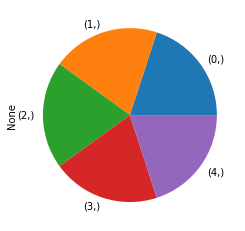

In [68]:
start = time.time()
feature_list = list(ANOVA_fs4["features_selected"].values) + list(chi2_fs4["features_selected"].values) + ["target"]
data = combined_df4.loc[:, combined_df4.columns.isin(feature_list)]
cols = data.select_dtypes("category").columns
data[cols] = data[cols].astype("int64")
X4, y4 = data.loc[:, ~data.columns.isin(["target"])], data.loc[:, data.columns.isin(["target"])]
X4, y4 = oversampling(X4, y4, plot=True)

In [91]:
def optimize(params, x, y):
    clf = LGBMClassifier(**params, random_state=123)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []

    for idx in kf.split(X=x,y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        clf.fit(xtrain,ytrain)
        preds =  clf.predict(xtest)
        fold_acc = metrics.recall_score(ytest,preds, average="micro")
        accuracies.append(fold_acc)

    return -1.0 * np.mean(accuracies)

#defining a set of values as hp for hyperparameters

param_space = {
                "max_depth" : scope.int(hp.quniform("max_depth",3, 20, 1)) ,
                "n_estimators": scope.int(hp.quniform("n_estimators",100,1500,1)),
                'learning_rate': hp.uniform("learning_rate",0.01,1),
                'num_leaves': scope.int(hp.quniform('num_leaves', 24, 80, 1)),
                'subsample': hp.uniform("subsample", 0.01, 1.0)}
                                            
#defiing optimization_fuction as partial and calling optimize within it
optimization_fuction = partial(optimize, x = np.array(X4), y = np.array(y4)) 
trials = Trials()

#Getting the optimum values for hyperparameters
result = fmin(
    fn = optimization_fuction,
    space = param_space,
    algo = tpe.suggest,
    max_evals = 15,
    trials = trials,
)

end = time.time()
#Printing the best hyperparemeter set
print(result)

# print Execution time
print("Execution time is: ", end - start, "seconds")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [1:03:20<00:00, 253.36s/trial, best loss: -0.9999496855345912]
{'learning_rate': 0.6960720013050441, 'max_depth': 6.0, 'n_estimators': 1181.0, 'num_leaves': 69.0, 'subsample': 0.3646666061385309}
Execution time is:  4532.2736120224 seconds


In [100]:
def optimize(params, x, y):
    clf = LGBMClassifier(**params, random_state=123)
    kf = model_selection.StratifiedKFold(n_splits=5)
    accuracies = []

    for idx in kf.split(X=x,y=y):
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]
        clf.fit(xtrain,ytrain)
        preds =  clf.predict(xtest)
        fold_acc = metrics.recall_score(ytest,preds, average="macro")
        accuracies.append(fold_acc)

    return -1.0 * np.mean(accuracies)

#defining a set of values as hp for hyperparameters
param_space2 = {'boosting_type': hp.choice('boosting_type',['gbdt','dart','goss']),
                'subsample_for_bin': scope.int(hp.quniform('subsample_for_bin', 20000, 300000, 20000)),
                'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
                'reg_alpha': hp.choice('reg_alpha', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
                'reg_lambda': hp.choice('reg_lambda', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
                "max_depth" : scope.int(hp.quniform("max_depth",3, 20, 1)) ,
                "n_estimators": scope.int(hp.quniform("n_estimators",100,1500,1)),
                'learning_rate': hp.uniform("learning_rate",0.01,1),
                'num_leaves': scope.int(hp.quniform('num_leaves', 24, 80, 1)),
                'subsample': hp.uniform("subsample", 0.01, 1.0)}
                                            
#defiing optimization_fuction as partial and calling optimize within it
optimization_fuction2 = partial(optimize, x = np.array(X4), y = np.array(y4)) 
trials2 = Trials()

#Getting the optimum values for hyperparameters
result2 = fmin(
    fn = optimization_fuction2,
    space = param_space2,
    algo = tpe.suggest,
    max_evals = 15,
    trials = trials2,
)

end = time.time()
#Printing the best hyperparemeter set
print(result2)

# print Execution time
print("Execution time is: ", end - start, "seconds")

[LightGBM] [Warning] feature_fraction is set=0.7695055504773101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7695055504773101                        
[LightGBM] [Warning] feature_fraction is set=0.7695055504773101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7695055504773101                        
[LightGBM] [Warning] feature_fraction is set=0.7695055504773101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7695055504773101                        
[LightGBM] [Warning] feature_fraction is set=0.7695055504773101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7695055504773101                        
[LightGBM] [Warning] feature_fraction is set=0.7866052491648541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7866052491648541                        
[LightGBM] [Warning] feature_fraction is set=0.7866052491648541, colsample_bytree=1.0 will be ignored. Current

[LightGBM] [Warning] feature_fraction is set=0.9332496184210717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9332496184210717                        
[LightGBM] [Warning] feature_fraction is set=0.9332496184210717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9332496184210717                        
[LightGBM] [Warning] feature_fraction is set=0.9332496184210717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9332496184210717                        
[LightGBM] [Warning] feature_fraction is set=0.5820998731289534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820998731289534                        
[LightGBM] [Warning] feature_fraction is set=0.5820998731289534, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5820998731289534                        
[LightGBM] [Warning] feature_fraction is set=0.5820998731289534, colsample_bytree=1.0 will be ignored. Current